# Zadanie 1: Korpusy anotowane oraz osadzenia słów i tekstów
K. Noculak, J. Tarasenko, J. Wąsala, B. Wrzalski

In [ ]:
import json

import fasttext
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
import seaborn as sns
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file, show
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
from sklearn.cluster import HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import (adjusted_rand_score,
                             homogeneity_completeness_v_measure,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

## 1. Anotacje

Do realizacji tego zadania wybraliśmy podzbiór recenzji hoteli ze zbioru PolEmo 2.0 [1] o liczności 300 wpisów. W ramach anotacji wykonaliśmy dwa zadania:
1. anotacja sentymentu (plus, minus, zero, amb) - cały tekst
2. anotacja aspektów (widoki, sen, jedzenie, obsługa) - fragmenty tekstu

Do realizacji pierwszej części wykorzystaliśmy arkusz Google Spreadsheets, w którym każdy z anotatorów miał do dyspozycji swój zeszyt z przypisanymi do niego wpisami. Metryki zgodności (kappy Cohena i Fleissa) zostały wyznaczone za pomocą wbudowanych funkcji w arkuszu.

Druga część zadania została zrealizowana przy pomocy narzędzia Doccano. Utworzyliśmy własną instancję z wykorzystaniem platformy Heroku, a następnie zamieściliśmy w niej plik z recenzjami. W tym przypadku nie było możliwości bezpośredniego wyliczenia metryk w narzędziu, dlatego po każdej iteracji dokonywaliśmy eksportu danych do osobnego pliku, a następnie były one przekazywane do przygotowanego przez nas programu, który wyznaczał metryki zgodności. Kod programu znajduje się w osobnym notatniku o nazwie `kappy.ipynb`.

![](spreadsheets_annotation.png)

Rys 1. Fragment arkusza Google Spreadsheets z anotacją sentymentu

![](doccano_annotation.png)

Rys 2. Fragment anotacji aspektów w Doccano

![](annotation_metrics.png)

Rys 3. Wyniki metryk zgodności dla obu zadań

### 1.1. Zwięzły opis statystyczny zbioru

In [11]:
data = pd.read_json("./data/out/text_annotations.json")
data["count_words"] = data["text"].apply(lambda x: len(x.split()))
data["count_chars"] = data["text"].apply(lambda x: len(x))

print(f"Number of entries: {len(data)}")
data.groupby("sentiment")[["count_words", "count_chars"]].describe()

Number of entries: 250


count_words                                                      \
                count        mean        std   min     25%    50%     75%   
sentiment                                                                   
Amb              44.0  119.090909  64.085632  49.0   66.50   96.5  152.75   
Minus           103.0  156.495146  96.956618  38.0   83.50  130.0  205.50   
Plus             81.0  120.456790  77.805374  46.0   69.00   99.0  142.00   
Zero             22.0  127.363636  24.845322  83.0  109.25  134.5  146.50   

                 count_chars                                                \
             max       count        mean         std    min     25%    50%   
sentiment                                                                    
Amb        305.0        44.0  656.159091  348.257252  283.0  397.75  550.0   
Minus      484.0       103.0  872.126214  523.435459  222.0  484.50  728.0   
Plus       475.0        81.0  682.901235  431.357236  267.0  394.00  562.0   
Zero       169.0        22.0  775.454545  157.432896  485.0  682.00  774.5   

                           
              75%     max  
sentiment                  
Amb         848.5  1710.0  
Minus      1163.5  2527.0  
Plus        845.0  2563.0  
Zero        895.5  1036.0

Tabela 1. Opis statystyczny liczby słów i znaków w zbiorze wg przypisanego sentymentu.

## Część 2: wektoryzacja fragmentów tekstu

In [ ]:
# Załadowanie danych z pliku word_annotations.json
with open('word_annotations.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Przekształcenie danych w DataFrame
df = pd.DataFrame(data)

print(df.head())


   text_id                                           fragment          label
0     4015  Właśnie wróciła m z motelu Flora w Łodzi , ul ...  Brak etykiety
1     4015           natomiast Panie Właścicielki - KOSZMAR .        Obsługa
2     4015                 Zapłacili śmy wcześniej za pobyt ,  Brak etykiety
3     4015  nie mogli śmy się wycofać i to chyba PANIOM do...        Obsługa
4     4015  za wszelką cenę chciały wyrzucić nas z ogródka...        Obsługa


In [ ]:
df_new = df[df["label"] != "Brak etykiety"].copy()

### 2.1. Word2Vec

In [ ]:
word2vec_model = KeyedVectors.load_word2vec_format('nkjp+wiki-forms-all-300-skipg-hs-50.txt.gz', binary=False)

In [ ]:
# Funkcja, która zwraca wektor dla słowa
def get_word_vector(word, model):
    try:
        return model[word]
    except KeyError:
        # Jeśli słowo nie jest w modelu, zwracamy wektor zerowy
        return np.zeros(model.vector_size)

# Funkcja, która zwraca wektor dla całego tekstu (uśredniony wektor słów)
def get_text_vector(text, model):
    word_vectors = [get_word_vector(word, model) for word in text.split()]
    
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        # Jeśli tekst jest pusty lub brak wektorów, zwracamy wektor zerowy
        return np.zeros(model.vector_size)

# Tworzymy wektory dla każdego fragmentu tekstu
df_new.loc[:, 'vector'] = df_new['fragment'].apply(lambda x: get_text_vector(x, word2vec_model))

# Sprawdzamy, czy każdy wektor ma ten sam wymiar
print(df_new['vector'].apply(lambda x: x.shape))


1       (300,)
3       (300,)
4       (300,)
6       (300,)
8       (300,)
         ...  
1388    (300,)
1390    (300,)
1392    (300,)
1394    (300,)
1396    (300,)
Name: vector, Length: 599, dtype: object


In [ ]:
df_new

,text_id,fragment,label,vector
1,4015,natomiast Panie Właścicielki - KOSZMAR .,Obsługa,"[-0.011928832779328028, 0.024840001327296097, ..."
3,4015,nie mogli śmy się wycofać i to chyba PANIOM do...,Obsługa,"[0.08407300027708213, 0.008693584240972996, -0..."
4,4015,za wszelką cenę chciały wyrzucić nas z ogródka...,Obsługa,"[0.05559050196316093, -0.059623502753674985, -..."
6,4015,"Zrugały nas za to , że zamówili śmy pizzę",Obsługa,"[0.1127023334459712, 0.05186211152209176, -0.1..."
8,4015,Menager przepraszała za bezczelne pracodawczyn...,Obsługa,"[-0.03466400042331467, -0.09817900011936824, -..."
...,...,...,...,...
1388,4364,Napoje dozowane z dystrybutorów wykonane są z ...,Jedzenie,"[-0.04563772813840346, 0.05686454457992857, 0...."
1390,4364,Piwo rozcieńczone wodą,Jedzenie,"[-0.01748966674009959, 0.030957665915290516, -..."
1392,4364,nieprzeszkolona barmanka nie umiała wyregulowa...,Obsługa,"[-0.03786900142828623, 0.05281950036684672, -0..."
1394,4364,Kolejnym problemem jest komunikacja po polsku ...,Obsługa,"[-0.041974400915205476, -0.015470299124717712,..."


Tabela 2. Fragmenty tekstu wraz z osadzeniami Word2Vec.

In [ ]:
# Redukcja wymiarowości za pomocą t-SNE
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=128)
X = np.vstack(df_new['vector'].values)
y = LabelEncoder().fit_transform(df_new['label'])
tsne_results = tsne.fit_transform(X)
df_new['tsne'] = list(tsne_results)

In [ ]:
trace_tsne = go.Scatter(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    mode='markers',
    showlegend=True,
    marker=dict(
        size=8,
        color=y,
        colorscale='Jet',
    ),
    text=df_new['fragment'],
)

layout = go.Layout(title='t-SNE reduction of word2vec vectors', width=800, height=800)
fig = go.Figure(data=[trace_tsne], layout=layout)
py.iplot(fig)

Rys 4. Osadzenia fragmentów tekstu dla modelu Word2Vec po redukcji wymiarów za pomocą t-SNE. Legenda: jasnoniebieski - obsługa, ciemnoniebieski - jedzenie, żółty - sen, brązowy - widoki.

In [ ]:
# Przygotowanie danych do wykresu Bokeh
df_new.loc[:, 'x'] = df_new['tsne'].apply(lambda x: x[0])
df_new.loc[:, 'y'] = df_new['tsne'].apply(lambda x: x[1])
source = ColumnDataSource(df_new)

hover = HoverTool(tooltips=[('Fragment', '@fragment'), ('Label', '@label')])

p = figure(title='t-SNE Word Embeddings', tools=[hover], width=800, height=800)
p.scatter('x', 'y', size=10, source=source)

output_file("word_embeddings.html")
show(p)


In [ ]:
# Funkcja do znalezienia k-najbardziej podobnych słów
def most_similar_words(word, df, k=5):
    if word not in df['fragment'].values:
        return []
    
    # Wektor dla zadanego słowa
    word_vector = df.loc[df['fragment'] == word, 'vector'].values[0]
    
    # Podobieństwo kosinusowe dla wszystkich słów
    similarities = cosine_similarity([word_vector], np.vstack(df['vector'].values))[0]
    
    # Połączenie słow z ich podobieństwem
    similar_words = list(zip(df['fragment'], similarities))
    
    # Sortowanie według podobieństwa i wybór top k
    similar_words = sorted(similar_words, key=lambda x: x[1], reverse=True)[1:k+1]
    
    return similar_words

# Przykład dla kilku słów
word_1 = df_new['fragment'].values[0]
similar_words = most_similar_words(word_1, df_new)
print(word_1)
display(pd.DataFrame(similar_words, columns=['fragment', 'similarity']))

word_2 = df_new['fragment'].values[1]
similar_words = most_similar_words(word_2, df_new)
print(word_2)
display(pd.DataFrame(similar_words, columns=['fragment', 'similarity']))

natomiast Panie Właścicielki - KOSZMAR .


,fragment,similarity
0,Panie w recepcji - cudowne i cóż z tego ?,0.559427
1,Panie na recepcji bardzo miłe,0.549812
2,To najlepszy hotel w jakim była m pod względem...,0.545209
3,Panie pracujące w recepcji nie podpisują sie w...,0.499109
4,Panie sprzątające mogły by się bardziej starać...,0.470265


nie mogli śmy się wycofać i to chyba PANIOM dodało odwagi ,


,fragment,similarity
0,"we wszystkim brakowało przypraw , i to nie żeb...",0.755022
1,"Śniadanie też uważam , że za skromne jak za tą...",0.733801
2,"niadanie było proste , choć muszę przyznać , ż...",0.729608
3,"by m nie pomyślał , że da się tak zepsuć frytki",0.709401
4,Jakiś buc ( domniemam że właściciel ) siedzący...,0.708772


Tabela 3. Przykłady dwóch zdań oraz najbardziej podobnych do nich fragmentów wg miary cosinusowej (osadzenia Word2Vec).

### 2.2. FastText

In [ ]:
model = fasttext.load_model(hf_hub_download(repo_id="facebook/fasttext-pl-vectors", filename="model.bin"))

In [ ]:
def get_text_vector_fasttext(text, model):
    return model.get_sentence_vector(text)

In [ ]:
df_new['fasttext_vector'] = df['fragment'].apply(lambda x: get_text_vector_fasttext(x, model))

In [ ]:
df_new[['fragment', 'label', 'fasttext_vector']]

,fragment,label,fasttext_vector
1,natomiast Panie Właścicielki - KOSZMAR .,Obsługa,"[0.0041652485, 0.035627414, 0.017866232, 0.021..."
3,nie mogli śmy się wycofać i to chyba PANIOM do...,Obsługa,"[-0.001226044, -0.0016228049, 0.018858662, -0...."
4,za wszelką cenę chciały wyrzucić nas z ogródka...,Obsługa,"[-0.012786967, 0.020502498, 0.0075052367, 0.00..."
6,"Zrugały nas za to , że zamówili śmy pizzę",Obsługa,"[0.015408729, -0.0038041344, 0.0034508347, -0...."
8,Menager przepraszała za bezczelne pracodawczyn...,Obsługa,"[-0.016231846, -0.0039035508, -0.0020870843, 0..."
...,...,...,...
1388,Napoje dozowane z dystrybutorów wykonane są z ...,Jedzenie,"[-0.010172996, 0.030776422, 0.00966832, 0.0129..."
1390,Piwo rozcieńczone wodą,Jedzenie,"[0.0040252386, 0.031913497, -0.014905117, -0.0..."
1392,nieprzeszkolona barmanka nie umiała wyregulowa...,Obsługa,"[-0.0106102, -0.034817766, 0.012042391, -0.004..."
1394,Kolejnym problemem jest komunikacja po polsku ...,Obsługa,"[-0.052566547, 0.026481584, 0.014810613, 0.040..."


Tabela 4. Fragmenty tekstu wraz z osadzeniami FastText.

In [ ]:
# Redukcja wymiarowości za pomocą t-SNE
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=128)
X = np.vstack(df_new['fasttext_vector'].values)
tsne_results = tsne.fit_transform(X)
df_new['fasttext-tsne'] = list(tsne_results)

In [ ]:
# tsne plot
trace_tsne = go.Scatter(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    mode='markers',
    showlegend=True,
    marker=dict(
        size=8,
        color=y,
        colorscale='Jet',
    ),
    text=df_new['fragment'],
)

layout = go.Layout(title='t-SNE reduction of fasttext vectors', width=800, height=800)
fig = go.Figure(data=[trace_tsne], layout=layout)
py.iplot(fig)

Rys 5. Osadzenia fragmentów tekstu dla modelu FastText po redukcji wymiarów za pomocą t-SNE. Legenda: jasnoniebieski - obsługa, ciemnoniebieski - jedzenie, żółty - sen, brązowy - widoki.

In [ ]:
# Funkcja do znalezienia k-najbardziej podobnych słów
def most_similar_words(word, df, k=5):
    if word not in df['fragment'].values:
        return []
    
    # Wektor dla zadanego słowa
    word_vector = df.loc[df['fragment'] == word, 'fasttext_vector'].values[0]
    
    # Podobieństwo kosinusowe dla wszystkich słów
    similarities = cosine_similarity([word_vector], np.vstack(df['fasttext_vector'].values))[0]
    
    # Połączenie słow z ich podobieństwem
    similar_words = list(zip(df['fragment'], similarities))
    
    # Sortowanie według podobieństwa i wybór top k
    similar_words = sorted(similar_words, key=lambda x: x[1], reverse=True)[1:k+1]
    
    return similar_words

# Przykład dla kilku słów
word_1 = df_new['fragment'].values[0]
similar_words = most_similar_words(word_1, df_new)
print(word_1)
display(pd.DataFrame(similar_words, columns=['fragment', 'similarity']))

word_2 = df_new['fragment'].values[1]
similar_words = most_similar_words(word_2, df_new)
print(word_2)
display(pd.DataFrame(similar_words, columns=['fragment', 'similarity']))

natomiast Panie Właścicielki - KOSZMAR .


,fragment,similarity
0,"Myślały , że ustne zapewnienie recepcjonistki ...",0.702838
1,Pani w recepcji ( p . Katarzyna Jajeczna - kie...,0.685552
2,Pan Parkingowy - miły człowiek .,0.682779
3,"Bardzo uprzejma obsługa , szczególnie Panie po...",0.681109
4,śniadania - porażka .,0.674646


nie mogli śmy się wycofać i to chyba PANIOM dodało odwagi ,


,fragment,similarity
0,"we wszystkim brakowało przypraw , i to nie żeb...",0.843715
1,"by m nie pomyślał , że da się tak zepsuć frytki",0.818829
2,"kelner stwierdził , że każdy może tak sobie mó...",0.817648
3,"Śniadanie też uważam , że za skromne jak za tą...",0.807114
4,"Obsługa sprawę olewa i udaje , że nic się nie ...",0.800575


Tabela 5. Przykłady dwóch zdań oraz najbardziej podobnych do nich fragmentów wg miary cosinusowej (osadzenia FastText).

## Część 3: wektoryzacja całego tekstu

### 3.1. FastText

In [ ]:
pd.set_option("display.max_colwidth", 250)

In [ ]:
data = pd.read_json("text_annotations.json")

In [ ]:
data

,text,sentiment
0,"Właśnie wróciła m z motelu Flora w Łodzi , ul . Szczecińska 111 . Nigdy nie była m w gorszym miejscu , otoczenie fajne , natomiast Panie Właścicielki - KOSZMAR . Zapłacili śmy wcześniej za pobyt , nie mogli śmy się wycofać i to chyba PANIOM dodał...",Minus
1,"Apartament zlokalizowany jest w samym centrum Starego Miasta , zaledwie kilka kroków od Rynku i tylko kilka minut spacerem od Dworca Głównego . W zasięgu ręki największe atrakcje Krakowa , tuż "" pod nosem "" restauracje , puby , sklepy . Apartamen...",Plus
2,"Laurent Picheral , nie będzie się ubiegał o wybór na stanowisko Prezesa Orbis S . A . w zarządzie kolejnej kadencji , w związku z decyzją o powołaniu go do Komitetu Wykonawczego Accor z dniem 1 lipca 2014 roku . Kadencja obecnego zarządu Orbis S ...",Zero
3,"Trudno w tej chwili powiedzieć , jak długo potrwa to ożywienie i czy przyniesie w rezultacie wyraźniejszy wzrost obrotu na rynku wtórnym . Być może osłabnie , gdy sytuacja gospodarcza wyjdzie ze stanu niepewności i zacznie się stabilizować . W ka...",Zero
4,"Pod koniec pobytu z pokoju podczas sprzątania zniknęło mi kilka przedmiotów osobistych ( drobnych , ale jednak zniknęło ) . Przy wymeldowywaniu recepcja nawet nie przeprosiła za zaistniały fakt . Obiecano szybko rozwiązać sprawę . Miała m czekać ...",Minus
...,...,...
245,"Obiekt położony przy jeziorze , okolica cicha , powietrze czyściutkie , zabawy dla małych dzieci zjazdy na sankach , workach i oponach na pobliskiej górce , spacery po lesie , karmienie zwierzaczków , kulig , basen i sala zabaw . Brak atrakcji dl...",Minus
246,"Niestety nie mogę wystawić temu hotelowi pochlebnej opinii . Zacznę od łazienki : tak mała , że osoba nieco większa ledwo się w niej mieści - siadając na wc można się z łatwością uderzyć o umywalkę . Specjalnie nie brali śmy żeli pod prysznic , b...",Minus
247,"U wrót do Tatrzańskiego Parku Narodowego i 10 min na Krupówki . Pensjonat czasy świetności - MSW ma za sobą . Obecnie spółka , chyba byli MSW ? Nie ważne . Dobre domowe jedzenie , czysto , mały basen , jedna sauna , jakuzi . Kilka minut w dolinę ...",Amb
248,"Hotel jest dobrze zlokalizowany , kilka kroków od rynku i zamku Wawelskiego oraz dworca PKP i PKS ułatwiają zwiedzanie Krakowa . Co to samego hotelu obsługa miła i pomocna , pokoje ładne i zadbane i nie drogie z możliwością zjedzenia śniadania kt...",Minus


Tabela 6. Całe teksty wraz z przypisanym sentymentem.

In [ ]:
model = fasttext.load_model("cc.pl.300.bin")

In [ ]:
sentiment = data["sentiment"].unique()
print(sentiment)

['Minus' 'Plus' 'Zero' 'Amb']


In [ ]:
positive = data[data["sentiment"] == "Plus"]
negative = data[data["sentiment"] == "Minus"]
zero = data[data["sentiment"] == "Zero"]
amb = data[data["sentiment"] == "Amb"]

In [ ]:
emb = [
    (model.get_sentence_vector(x), sentiment, text)
    for x, sentiment, text in zip(data["text"], data["sentiment"], data["text"])
]

In [ ]:
from sklearn.manifold import TSNE

import numpy as np

X = [x[0] for x in emb]
y = [x[1] for x in emb]

X = np.array(X)

X_embedded = TSNE(n_components=2).fit_transform(X)

df = pd.DataFrame(X_embedded, columns=["x", "y"])
df["sentiment"] = y
df["text_short"] = [e[2][:100] for e in emb]

fig = px.scatter(
    df,
    x="x",
    y="y",
    color="sentiment",
    hover_data={"text_short": True},
    color_discrete_sequence=px.colors.qualitative.Safe,
    height=600,
    width=800,
)

fig.update_layout(title_text="t-SNE visualization of sentiment embeddings")
fig.show()

Rys 6. Osadzenia całych tekstów dla modelu FastText po redukcji wymiarów za pomocą t-SNE.

In [ ]:
X_embedded = TSNE(n_components=3).fit_transform(X)

df = pd.DataFrame(X_embedded, columns=["x", "y", "z"])

df["sentiment"] = y
df["text_short"] = [e[2][:100] for e in emb]

fig = px.scatter_3d(
    df,
    x="x",
    y="y",
    z="z",
    color="sentiment",
    hover_data={"text_short": True},
    color_discrete_sequence=px.colors.qualitative.Safe,
    height=600,
    width=800,
)

fig.update_layout(title_text="t-SNE visualization of sentiment embeddings")
fig.show()

Rys 7. Osadzenia całych tekstów dla modelu FastText po redukcji wymiarów za pomocą t-SNE (3 wymiary).

In [ ]:
X

array([[-0.0094164 ,  0.00804476,  0.00927156, ...,  0.00965715,
         0.00217663, -0.00586179],
       [ 0.00989095,  0.00327411,  0.00555546, ...,  0.00653342,
        -0.01380682, -0.01256193],
       [ 0.00184379,  0.0031429 ,  0.02443219, ...,  0.01553421,
        -0.00803123, -0.01652799],
       ...,
       [ 0.00157971, -0.00441807, -0.00404004, ...,  0.01552678,
        -0.00295266, -0.01246801],
       [-0.0030038 ,  0.00913514,  0.01721907, ..., -0.0068825 ,
        -0.01131617, -0.0051673 ],
       [-0.00838824,  0.00186891,  0.00181287, ...,  0.00947329,
        -0.00973124, -0.02000425]], dtype=float32)

In [ ]:
clustering = HDBSCAN(min_cluster_size=2, max_cluster_size=150).fit(X)

df["cluster"] = clustering.labels_

fig = px.scatter(
    df,
    x="x",
    y="y",
    color=df["cluster"].astype(str),
    hover_data={"text_short": True, "sentiment": True},
    color_discrete_sequence=px.colors.qualitative.Safe,
    height=600,
    width=800,
)

fig.update_layout(
    title_text="HDBSCAN visualization of sentiment embeddings",
    legend=dict(traceorder="normal"),
)
fig.show()

Rys 8. Osadzenia całych tekstów dla modelu FastText po redukcji wymiarów za pomocą t-SNE (2 wymiary) z przypisanym klastrem z HDBSCAN.

In [ ]:
df

,x,y,sentiment,text_short,cluster
0,-3.153936,-3.649296,Minus,"Właśnie wróciła m z motelu Flora w Łodzi , ul . Szczecińska 111 . Nigdy nie była m w gorszym miejscu",-1
1,-0.323338,3.590384,Plus,"Apartament zlokalizowany jest w samym centrum Starego Miasta , zaledwie kilka kroków od Rynku i tylk",-1
2,-0.902419,8.103442,Zero,"Laurent Picheral , nie będzie się ubiegał o wybór na stanowisko Prezesa Orbis S . A . w zarządzie ko",-1
3,-3.492954,7.873285,Zero,"Trudno w tej chwili powiedzieć , jak długo potrwa to ożywienie i czy przyniesie w rezultacie wyraźni",4
4,2.862342,-5.169024,Minus,"Pod koniec pobytu z pokoju podczas sprzątania zniknęło mi kilka przedmiotów osobistych ( drobnych ,",9
...,...,...,...,...,...
245,0.793057,1.818248,Minus,"Obiekt położony przy jeziorze , okolica cicha , powietrze czyściutkie , zabawy dla małych dzieci zja",-1
246,0.860537,-1.837165,Minus,"Niestety nie mogę wystawić temu hotelowi pochlebnej opinii . Zacznę od łazienki : tak mała , że osob",11
247,-3.479824,1.890571,Amb,U wrót do Tatrzańskiego Parku Narodowego i 10 min na Krupówki . Pensjonat czasy świetności - MSW ma,-1
248,4.024527,0.652668,Minus,"Hotel jest dobrze zlokalizowany , kilka kroków od rynku i zamku Wawelskiego oraz dworca PKP i PKS uł",-1


Tabela 7. Całe teksty wraz ze składowymi t-SNE dla osadzeń FastText oraz z klastrem przypisanym przez HDBSCAN.

In [ ]:
ari = adjusted_rand_score(df["sentiment_idx"], df["cluster"])
nmi = normalized_mutual_info_score(df["sentiment_idx"], df["cluster"])
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
    df["sentiment_idx"], df["cluster"]
)

print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Normalized Mutual Information (NMI): {nmi}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-measure: {v_measure}")

Adjusted Rand Index (ARI): 0.013220869609742432
Normalized Mutual Information (NMI): 0.1400827696056062
Homogeneity: 0.12493006433118854
Completeness: 0.1594185683540548
V-measure: 0.1400827696056062


In [ ]:
max_cluster_sizes = np.linspace(2, 200, 20, dtype=int)
ari_scores = []
nmi_scores = []
silhouette_scores = []
for max_cluster_size in max_cluster_sizes:
    clustering = HDBSCAN(min_cluster_size=2, max_cluster_size=max_cluster_size).fit(X)
    df["cluster"] = clustering.labels_

    ari = adjusted_rand_score(df["sentiment_idx"], df["cluster"])
    nmi = normalized_mutual_info_score(df["sentiment_idx"], df["cluster"])
    silhouette = silhouette_score(X, df["cluster"])

    ari_scores.append(ari)
    nmi_scores.append(nmi)
    silhouette_scores.append(silhouette)


max_cluster_sizes = np.linspace(2, 200, 20, dtype=int)
ari_scores = []
nmi_scores = []
silhouette_scores = []

for max_cluster_size in max_cluster_sizes:
    clustering = HDBSCAN(min_cluster_size=2, max_cluster_size=max_cluster_size).fit(X)
    df["cluster"] = clustering.labels_

    ari = adjusted_rand_score(df["sentiment_idx"], df["cluster"])
    nmi = normalized_mutual_info_score(df["sentiment_idx"], df["cluster"])
    silhouette = silhouette_score(X, df["cluster"])

    ari_scores.append(ari)
    nmi_scores.append(nmi)
    silhouette_scores.append(silhouette)

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=max_cluster_sizes, y=ari_scores, mode="lines+markers", name="ARI")
)
fig.add_trace(
    go.Scatter(x=max_cluster_sizes, y=nmi_scores, mode="lines+markers", name="NMI")
)
fig.add_trace(
    go.Scatter(
        x=max_cluster_sizes,
        y=silhouette_scores,
        mode="lines+markers",
        name="Silhouette",
    )
)


fig.update_layout(
    title="Clustering Metrics for Different Max Cluster Sizes",
    xaxis_title="Max Cluster Size",
    yaxis_title="Score",
    legend_title="Metrics",
    height=600,
    width=800,
)


fig.update_layout(
    title="Clustering Metrics for Different Max Cluster Sizes",
    xaxis_title="Max Cluster Size",
    yaxis_title="Score",
    legend_title="Metrics",
    height=600,
    width=800,
)

fig.show()

Rys. 9 Wykres zależności wartości metryk ARI, NMI i Silhouette (porównujących klasteryzację HDBSCAN z etykietami sentymentów) od maksymalnego rozmiaru klastra HDBSCAN.

### 3.2. TF-IDF

In [ ]:
data = pd.read_json("../data/out/text_annotations.json")
data["sentiment_id"] = data["sentiment"].factorize()[0]
data["text_short"] = data["text"].str.slice(0, 100)

In [ ]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(data.text)

In [ ]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 21213 stored elements and shape (250, 8197)>

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=200)

X_tsne = tsne.fit_transform(X.toarray())

In [ ]:
data_tsne = pd.merge(data, pd.DataFrame(X_tsne, columns=["x", "y"]), left_index=True, right_index=True)

### TFIDF - t-SNE

In [ ]:
fig = px.scatter(data_tsne, x="x", y="y", color="sentiment", hover_data=["text_short"])
fig.show()

Rys 10. Osadzenia całych tekstów dla modelu TF-IDF po redukcji wymiarów za pomocą t-SNE.

### TFIDF - HDBSCAN

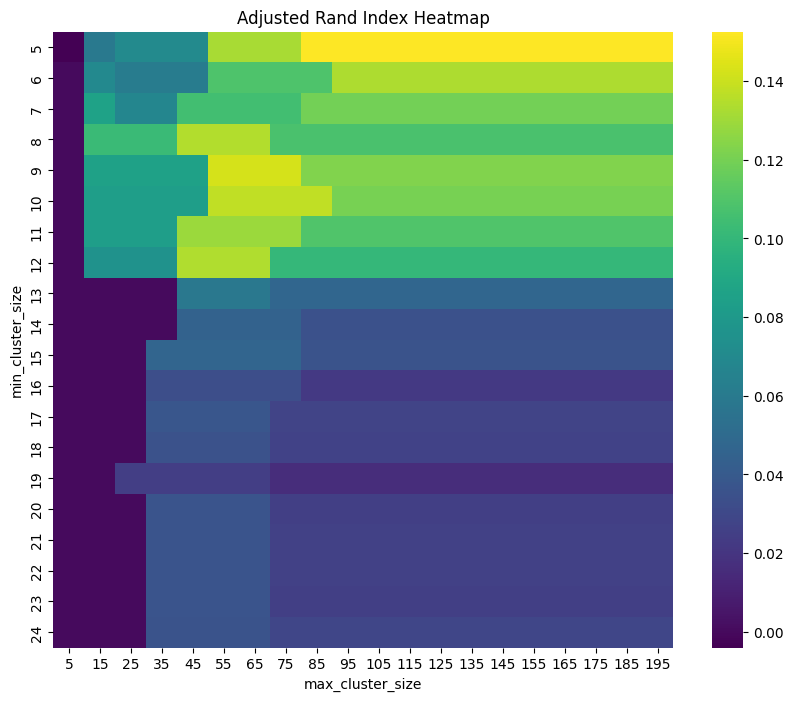

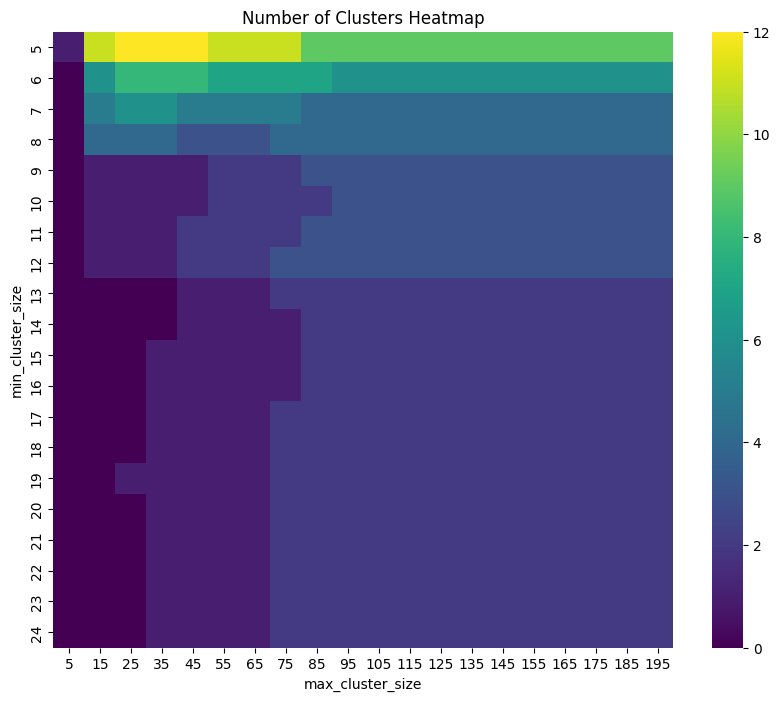

In [ ]:
min_cluster_sizes = range(5, 25, 1)
max_cluster_sizes = range(5, 201, 10)
ari_matrix = np.zeros((len(min_cluster_sizes), len(max_cluster_sizes)))

for i, min_size in enumerate(min_cluster_sizes):
    for j, max_size in enumerate(max_cluster_sizes):
        clusterer = HDBSCAN(min_cluster_size=min_size, max_cluster_size=max_size)
        cluster_labels = clusterer.fit_predict(X_tsne)
        ari = adjusted_rand_score(data["sentiment_id"], cluster_labels)
        ari_matrix[i, j] = ari

plt.figure(figsize=(10, 8))
sns.heatmap(
    ari_matrix,
    xticklabels=max_cluster_sizes,
    yticklabels=min_cluster_sizes,
    cmap="viridis",
)
plt.xlabel("max_cluster_size")
plt.ylabel("min_cluster_size")
plt.title("Adjusted Rand Index Heatmap")
plt.show()

num_clusters_matrix = np.zeros((len(min_cluster_sizes), len(max_cluster_sizes)))

for i, min_size in enumerate(min_cluster_sizes):
    for j, max_size in enumerate(max_cluster_sizes):
        clusterer = HDBSCAN(min_cluster_size=min_size, max_cluster_size=max_size)
        cluster_labels = clusterer.fit_predict(X_tsne)
        num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        num_clusters_matrix[i, j] = num_clusters

plt.figure(figsize=(10, 8))
sns.heatmap(
    num_clusters_matrix,
    xticklabels=max_cluster_sizes,
    yticklabels=min_cluster_sizes,
    cmap="viridis",
)
plt.xlabel("max_cluster_size")
plt.ylabel("min_cluster_size")
plt.title("Number of Clusters Heatmap")
plt.show()

Rys 11. Porównanie klastrów HDBSCAN oraz metryki ARI (pomiędzy klastrami HDBSCAN a anotacjami) zależnie od parametrów min_cluster_size i max_cluster_size, dla osadzeń TF-IDF.

In [ ]:
clusterer = HDBSCAN(min_cluster_size=5, max_cluster_size=100)
cluster_labels = clusterer.fit_predict(X_tsne)

data_tsne["cluster"] = cluster_labels

fig = px.scatter(
    data_tsne, x="x", y="y", color="cluster", hover_data=["text_short", "sentiment"],
    title="t-SNE Clustering with HDBSCAN"
)
fig.update_layout(coloraxis_colorbar=dict(tickvals=list(range(len(set(cluster_labels))))))
fig.show()

Rys 12. Osadzenia całych tekstów dla modelu TF-IDF po redukcji wymiarów za pomocą t-SNE (2 wymiary) z przypisanym klastrem z HDBSCAN.

## Przypisy
[1] Kocoń, Jan, Monika Zaśko-Zielińska, and Piotr Miłkowski. "PolEmo 2.0 sentiment analysis dataset for CoNLL." (2019)